In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import time

from sklearn.metrics import mean_absolute_error

In [2]:
limit_ListPrice = 1800
price_segment = 30
customer_traffic_segment = 0.0833 #5/(limit_ListPrice/price_segment)
competitiveness_segment = 0.0416 #2.5/(limit_ListPrice/price_segment)
epsilon = 0.4

# Dynamic Pricing with Reinforcement Learning

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/preprocessed_data_v3_sortbyvariance_profitrate.csv")
df

,DWHotelID,Unnamed: 0,w,Date,ListPriceTRY,PurchaseAmountTRY,RatingTripA,ProfitRate,featureScore,Date_year,Date_week,rooms_old,#rooms,empty_rooms,rewardrate,mean_profitrate,error_profitrate,variance_profitrate
0,589.0,7776,0.0,2013-21,261.333333,224.000000,4.5,0.166667,0.643136,2013,21,21.0,147.0,147.001,0.253967,0.305017,0.019141,0.033042
1,589.0,7777,0.0,2013-22,261.333333,224.000000,4.5,0.166667,0.643136,2013,22,21.0,147.0,147.001,0.253967,0.305017,0.019141,0.033042
2,589.0,7778,0.0,2013-23,261.333333,224.000000,4.5,0.166667,0.643136,2013,23,21.0,147.0,147.001,0.253967,0.305017,0.019141,0.033042
3,589.0,7779,0.0,2013-24,261.333333,224.000000,4.5,0.166667,0.643136,2013,24,21.0,147.0,147.001,0.253967,0.305017,0.019141,0.033042
4,589.0,7780,0.0,2013-25,261.333333,224.000000,4.5,0.166667,0.643136,2013,25,21.0,147.0,147.001,0.253967,0.305017,0.019141,0.033042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8869,154.0,9720,50.0,2017-21,1519.180000,1354.960000,4.5,0.121199,0.846329,2017,21,13.0,158.0,108.001,1.520541,0.129345,0.000066,0.000297
8870,154.0,9721,40.0,2017-22,1726.225000,1559.475000,4.5,0.106927,0.846329,2017,22,13.0,158.0,118.001,1.413124,0.129345,0.000503,0.000297
8871,154.0,9722,52.0,2017-23,1535.173077,1383.288462,4.5,0.109800,0.846329,2017,23,13.0,158.0,106.001,1.432860,0.129345,0.000382,0.000297
8872,154.0,9737,66.0,2017-38,1646.984848,1499.378788,4.5,0.098445,0.846329,2017,38,13.0,158.0,92.001,1.604396,0.129345,0.000955,0.000297


In [5]:
df = df[df['ListPriceTRY']<=limit_ListPrice]

In [6]:
print('Max Purchase Amount:', df['PurchaseAmountTRY'].max() , 'Min Purchase Amount:', df['PurchaseAmountTRY'].min())
print('Max List Price:', df['ListPriceTRY'].max() , 'Min List Price:', df['ListPriceTRY'].min() )
print('Max Rate:', df['RatingTripA'].max(), 'Min Rate:', df['RatingTripA'].min())
print('Max Feature Score:', df['featureScore'].max() , 'Min Feature Score:', df['featureScore'].min())
print('Max Room Count:', df['empty_rooms'].max() , 'Min Room Count:', df['empty_rooms'].min())

Max Purchase Amount: 1660.5 Min Purchase Amount: 34.0
Max List Price: 1800.0 Min List Price: 37.66666666666666
Max Rate: 5.0 Min Rate: 2.5
Max Feature Score: 2.2538542161050463 Min Feature Score: 0.469892026578073
Max Room Count: 488.001 Min Room Count: 0.001


In [7]:
# Utility function for creating discreate space
def round_specific(x, precision, base):
  return round(base * round(float(x)/base),precision)

In [8]:
class Sale:
    def __init__(self, purchase, customer_traffic, competitiveness, empty_rooms):
        self.profit = round_specific(np.random.rand()*0.2, 2, 0.01)
        self.purchase = purchase
        if self.purchase > limit_ListPrice:
            self.purchase = limit_ListPrice
        if self.purchase < 0:
            self.purchase = 0
        
        self.list_price = self.purchase + self.purchase*self.profit
        self.list_price = round_specific(self.list_price, 0, price_segment)
        if self.list_price > limit_ListPrice:
            self.list_price = limit_ListPrice
        if self.list_price < 0:
            self.list_price = 0

        self.customer_traffic = customer_traffic
        self.competitiveness = competitiveness
        self.empty_rooms = empty_rooms
    
    def __str__(self):
        return f"{self.profit}"
    
    def __sub__(self,other):
        return self.profit - other.profit
    
    def action(self, choice):
        if choice == 0:
            self.change(-5) # profiti %5 indir
        elif choice == 1:
            self.change(0) 
        elif choice == 2:
            self.change(+10) 
        """
        elif choice == 3:
            self.change(+5) 
        elif choice == 4:
            self.change(+10) # profiti %10 arttir 
        """
    
    def change(self, p=False):
        if not p:
            self.profit = round_specific(np.random.rand(), 2, 0.01)
        else:
            self.profit = self.profit + (p/100)
            
        self.list_price = self.purchase + self.purchase*self.profit 
        self.list_price = round_specific(self.list_price, 0, price_segment)
        if self.list_price > limit_ListPrice:
            self.list_price = limit_ListPrice
        if self.list_price < 0:
            self.list_price = 0

In [9]:
q_table_main = np.load('/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/qtable/q_table_30_1800_3acts.npy',allow_pickle='TRUE').item()

In [10]:
def RL(HM_EPISODES, epsilon, df, q_table):
    EPS_DECAY = 0.998
    SHOW_EVERY = 100
    LEARNING_RATE = 0.1
    DISCOUNT = 0.95
    df['list_price']=np.nan

    episode_rewards = []

    for episode in range(HM_EPISODES):
    
        sale = df.iloc[episode]
        
        purchase = sale['PurchaseAmountTRY']
        purchase = round_specific(purchase, 0, price_segment)
        
        customer_traffic = sale['RatingTripA']
        customer_traffic = round_specific(customer_traffic, 1, customer_traffic_segment)
        
        competitiveness = sale['featureScore']
        competitiveness = round_specific(competitiveness, 2, competitiveness_segment)
        
        empty_rooms = sale['empty_rooms']
        
        agent = Sale(purchase, customer_traffic, competitiveness, empty_rooms)
        
        list_price = agent.list_price
        """
        if episode % SHOW_EVERY == 0:
            print(f"on #{episode}, epsilon is {epsilon}")
            print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
            show = True
        else:
            show = False
        """
        episode_reward = 0
        for i in range(200):
            obs = (purchase, list_price, customer_traffic, competitiveness)
            
            if np.random.random() > epsilon:
                # GET THE ACTION
                action = np.argmax(q_table[obs])
            else:
                action = np.random.randint(0, 3)
            
            # Take the action!
            agent.action(action)
            
            ##############################
            # REWARD FUNCTION
            new_obs = (agent.purchase, agent.list_price, agent.customer_traffic, agent.competitiveness)
            max_future_q = np.max(q_table[new_obs])
            
            #Kıymet
            #mean yapınca.
            #max_future_q = np.mean(q_table[new_obs])

   
            current_q = q_table[obs][action]
            


            rewardrate = (agent.list_price-agent.purchase)/ agent.empty_rooms
            
            if rewardrate < 1:
                reward = -300
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            elif rewardrate < 10 or rewardrate > 1000:
                new_q = rewardrate
                reward = 25
            else:
                reward = -1
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            
            q_table[obs][action] = new_q

            episode_reward += reward
            if reward ==25:
                break
        df['list_price'].iloc[episode] = agent.list_price
        #print(episode_reward)
        episode_rewards.append(episode_reward)
        epsilon *= EPS_DECAY

    moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')
    return df, moving_avg

**Hotel Based Pricing**

In [11]:
df_1M = df


df_list = [df_1M]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


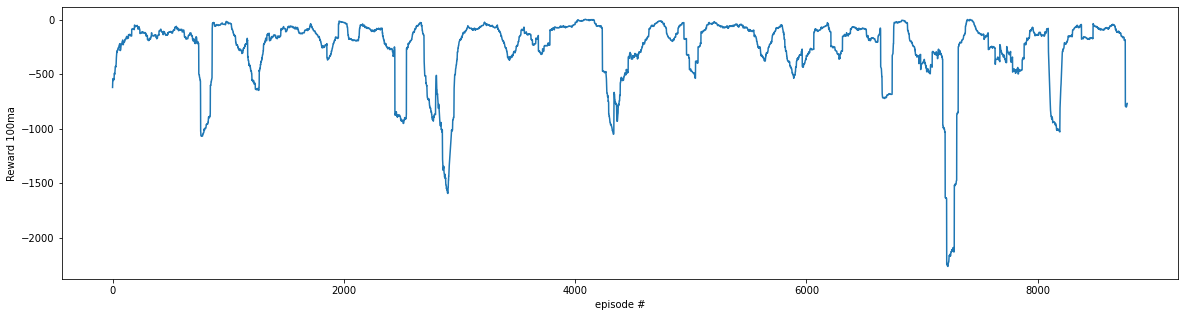

In [12]:
for data_frame in df_list:
  q_table = q_table_main.copy()
  data_frame.reset_index()
  data_frame, moving_avg = RL(data_frame.shape[0], epsilon, data_frame, q_table)
  
  plt.rcParams['figure.figsize'] = [20, 5]
  plt.plot([i for i in range(len(moving_avg))], moving_avg)
  plt.ylabel(f"Reward 100ma")
  plt.xlabel("episode #")
  plt.show()

<Figure size 1440x360 with 0 Axes>

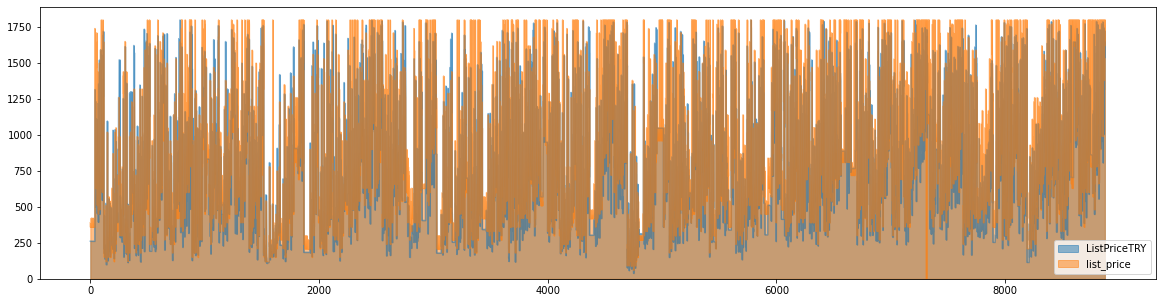

In [13]:
df_1M2 = df_1M[['ListPriceTRY','list_price']]
plt.figure();
plt.rcParams['figure.figsize'] = [20, 5]
df_1M2.plot.area(stacked=False);

**Original List Price Classfication**

In [14]:
# Utility function for creating discreate space
def round_specific_series(x, precision, base):
  return round(base * round(x/base),precision)

In [15]:
for x in df_list:
    x["ClassifiedListPriceTRY"] = round_specific_series(x["ListPriceTRY"], 0, 100)

**Mean Absolute Percentage Error**

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**Print Metrics**

In [17]:
def print_metrics(data_frame):

  print("*Number of Sales: ",data_frame.shape[0])
  print("*Mean Absolute Error: ", mean_absolute_error(data_frame['ListPriceTRY'],data_frame['list_price']));
  print("*Mean Absolute Error of Classified: ", mean_absolute_error(data_frame['ClassifiedListPriceTRY'],data_frame['list_price']));

  print("*h460 MAPE of Or-Re: ", mean_absolute_percentage_error(data_frame['ListPriceTRY'],data_frame['list_price']));
  print("*h460 MAPE of Cl-Re: ", mean_absolute_percentage_error(data_frame['ClassifiedListPriceTRY'],data_frame['list_price']));

  print("*Mean of Recommended List Prices:", data_frame['list_price'].mean())
  print("*Mean of Original List Prices:", data_frame['ListPriceTRY'].mean())
  print("*Mean of Classified List Prices:", data_frame['ClassifiedListPriceTRY'].mean())

  print("*Standard Deviation of Recommended List Prices:", data_frame['list_price'].std())
  print("*Standard Deviation of Original List Prices:", data_frame['ListPriceTRY'].std())
  print("*Standard Deviation of Classified List Prices:", data_frame['ClassifiedListPriceTRY'].std())
  
  return

In [18]:
for d in df_list:
  print_metrics(d)
  print("|")

*Number of Sales:  8874
*Mean Absolute Error:  136.14959395847177
*Mean Absolute Error of Classified:  139.26414243858463
*h460 MAPE of Or-Re:  20.873999307816796
*h460 MAPE of Cl-Re:  inf
*Mean of Recommended List Prices: 870.3820148749155
*Mean of Original List Prices: 788.7967323707594
*Mean of Classified List Prices: 788.8438133874239
*Standard Deviation of Recommended List Prices: 438.541429091732
*Standard Deviation of Original List Prices: 420.6451940356325
*Standard Deviation of Classified List Prices: 421.00483790636133
|


In [19]:
df_1M['col1'] = np.where(df_1M['ListPriceTRY'] > df_1M['list_price'], True, False)
df_1M['col2'] = np.where(df_1M['ListPriceTRY'] == df_1M['list_price'], True, False)
df_1M['col3'] = np.where(df_1M['ListPriceTRY'] < df_1M['list_price'], True, False)

In [20]:
df_1M

,DWHotelID,Unnamed: 0,w,Date,ListPriceTRY,PurchaseAmountTRY,RatingTripA,ProfitRate,featureScore,Date_year,Date_week,rooms_old,#rooms,empty_rooms,rewardrate,mean_profitrate,error_profitrate,variance_profitrate,list_price,ClassifiedListPriceTRY,col1,col2,col3
0,589.0,7776,0.0,2013-21,261.333333,224.000000,4.5,0.166667,0.643136,2013,21,21.0,147.0,147.001,0.253967,0.305017,0.019141,0.033042,390.0,300.0,False,False,True
1,589.0,7777,0.0,2013-22,261.333333,224.000000,4.5,0.166667,0.643136,2013,22,21.0,147.0,147.001,0.253967,0.305017,0.019141,0.033042,360.0,300.0,False,False,True
2,589.0,7778,0.0,2013-23,261.333333,224.000000,4.5,0.166667,0.643136,2013,23,21.0,147.0,147.001,0.253967,0.305017,0.019141,0.033042,360.0,300.0,False,False,True
3,589.0,7779,0.0,2013-24,261.333333,224.000000,4.5,0.166667,0.643136,2013,24,21.0,147.0,147.001,0.253967,0.305017,0.019141,0.033042,360.0,300.0,False,False,True
4,589.0,7780,0.0,2013-25,261.333333,224.000000,4.5,0.166667,0.643136,2013,25,21.0,147.0,147.001,0.253967,0.305017,0.019141,0.033042,390.0,300.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8869,154.0,9720,50.0,2017-21,1519.180000,1354.960000,4.5,0.121199,0.846329,2017,21,13.0,158.0,108.001,1.520541,0.129345,0.000066,0.000297,1800.0,1500.0,False,False,True
8870,154.0,9721,40.0,2017-22,1726.225000,1559.475000,4.5,0.106927,0.846329,2017,22,13.0,158.0,118.001,1.413124,0.129345,0.000503,0.000297,1800.0,1700.0,False,False,True
8871,154.0,9722,52.0,2017-23,1535.173077,1383.288462,4.5,0.109800,0.846329,2017,23,13.0,158.0,106.001,1.432860,0.129345,0.000382,0.000297,1800.0,1500.0,False,False,True
8872,154.0,9737,66.0,2017-38,1646.984848,1499.378788,4.5,0.098445,0.846329,2017,38,13.0,158.0,92.001,1.604396,0.129345,0.000955,0.000297,1620.0,1600.0,True,False,False


In [21]:
#df_1M.to_csv(r'/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/qlearning_results_3018003acts_v2.csv', index = False)
